<a href="https://www.kaggle.com/code/ujunwajoyclyn/credit-card-churn-datapreprocessing-model?scriptVersionId=124787314" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

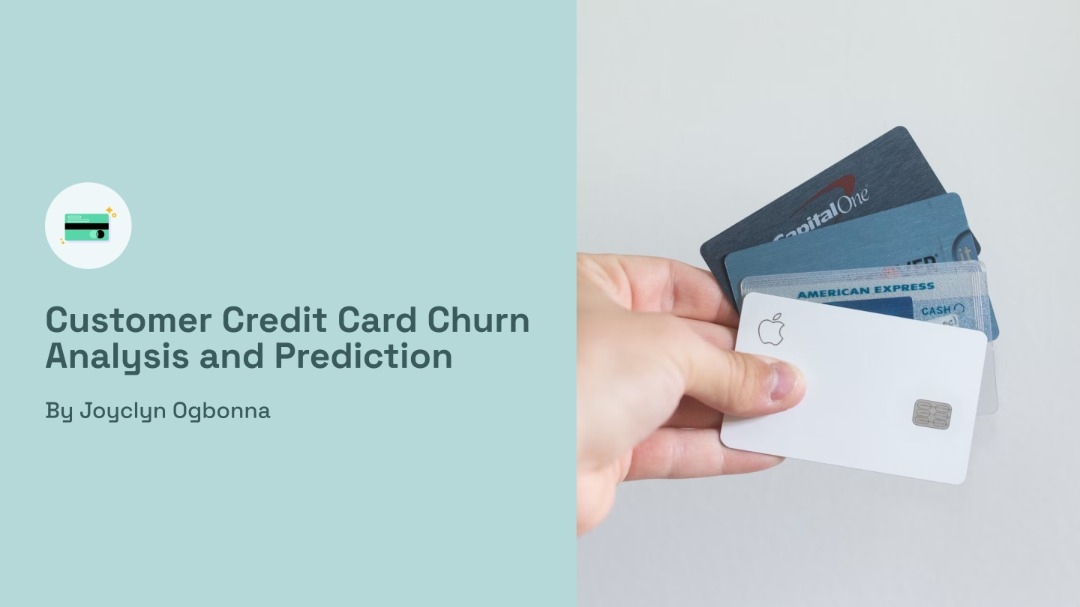

# **Objective**

* EDA: In the [previous notebook](https://www.kaggle.com/code/ujunwajoyclyn/credit-card-churn)
* Build 5 classifiers that predicts churners. The models are Logistic Regression, Random Forest Classifier, CatBoost, XGBoost and LightGBM.
    
    The purpose of building a churn classification model is to assign to check customers with a high certainty a probability of leaving the bank.
* Explore different concept and techniques of feature scaling and model evaluation metrics

# **Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

# **Data Loading**

In [2]:
data = pd.read_csv('/kaggle/input/customer-credit-card-churn/customer_churn_1.csv')
data.head(3) #display first three rows of data
data.shape #to find the number of columns and observations in the data

(10127, 20)

This data has 20 columns and 10127 observations. We will focus on the attrited_flag attribute.

# **Data Pre-Processing: Handling Categorical Attributes**

This is the conversion of categorical attribute from text to numerical value with one hot encoding and label encoding.

* **One hot encoding**: This converts categorical variables into a numerical binary form (0 and 1). The con is that it induces sparsity on the data and an alogrithm especially a decision tree would treat each dummy feature as an independent feature. This is bad and would make it difficult for the model to learn the features importance and have a good model performance.

* **Label encoding**: This replaces the categorical value with a numeric value between 0 and the number of classes minus 1. If the categorical variable value contains 5 distinct classes, the new value will be 0, 1, 2, 3, and 4. The con of label encoding is that some algorithms might misinterpret it as having some sort of hierachy or order, meaning that it might favour labels with higher number than lower numbers.

We will explore both ways of handling categorical text attribute and how ML algorithm will perform with both methods later on this notebook.

In [3]:
data_num = pd.get_dummies(data) #to perform one-hot encoding in categorical features

In [4]:
data_lab = data.copy() #make a new copy of data
lab = LabelEncoder() #label encoder
data_lab['gender']= lab.fit_transform(data_lab['gender']) #convert the categorical data in gender column to numeric
data_lab['education_level'] =  lab.fit_transform(data_lab['education_level']) #convert the categorical data in education_level column to numeric
data_lab['marital_status'] =  lab.fit_transform(data_lab['marital_status']) #convert the categorical data in marital_status column to numeric
data_lab['income_category'] =  lab.fit_transform(data_lab['income_category']) #convert the categorical data in income_category column to numeric
data_lab['card_category'] =  lab.fit_transform(data_lab['card_category']) #convert the categorical data in card_category column to numeric

# **Data Processing: Separate Target and Features**

In [5]:
target = data_num.attrition_flag #target in one-hot encoded data
features_num = data_num.drop(columns='attrition_flag') #feature in one-hot encoded data
features_lab = data_lab.drop(columns='attrition_flag') #feature in label encoded data

# **Data Preprocessing: Feature Scaling**

Feature scaling will be done because the data has value ranging from zero to hundreds of thousands. This could cause some models to give importance to numbers with higher values, whereas it shouldn't.

There are different techniques to transform data, they are:

* Robust scaler: this resists outliers and works on data that is not normally distributed
* Min-Max scaler: this works for non-uniformly distributed data
* Standard scaler: this works for uniformly distributed data
    
This shows that it is important to consider the data distribution and presence of outlier.
    
In [EDA](https:www.kaggle.com/code/ujunwajoyclyn/credit-card-churn), our data has a uniform distribution with few outliers. It is quite difficult to select a transformation technique to scale the input features.

We will explore: 

*     all three feature scaling techniques on one-hot encoded and label encoded features,
*     how ML algorithm will perform on all data scaled with all three feature scaling,
*     if some machine learning models do not require feature scaling.    

In [6]:
'''Robust Scaler'''
robust_scaler = RobustScaler() #robust scaler
#perform robust scaler on the features that are already one-hot encoded
robust_scaler.fit(features_num) 
robust_features_num = robust_scaler.transform(features_num)
#perform robust scaler on features that were label encoded
robust_scaler.fit(features_lab)
robust_features_lab = robust_scaler.transform(features_lab)

'''Min-Max Scaler'''
min_max_scaler = MinMaxScaler() #minmaxscaler
min_max_num= min_max_scaler.fit_transform(features_num) #perform Min-max scaler on one-hot endoded features
min_max_lab = min_max_scaler.fit_transform(features_lab) #perform Min-max scaler on label endoded features

'''Standard Scaler'''
standard_scaler = StandardScaler() #standard scaler
standard_num = standard_scaler.fit_transform(features_num) #perform standard scaler on one-hot endoded features
standard_lab = standard_scaler.fit_transform(features_lab) #perform standard scaler on label endoded features

After data preprocessing, there are now 8 different features data. They are:
* **features_num:** Features whose categorical attributes was converted with one-hot encoding without any feature scaling
* **features_lab:** Features whose categorical attributes was converted with label encoding without any feature scaling
* **robust_features_num:** Features wwhose categorical attributes was converted with one-hot encoding and transformed with robust scaler
* **robust_features_lab:** Features wwhose categorical attributes was converted with label encoding and transformed with robust scaler
* **min_max_num:** Features wwhose categorical attributes was converted with one-hot encoding and transformed with min-max scaler
* **min_max_lab:** Features wwhose categorical attributes was converted with label encoding and transformed with min-max scaler
* **standard_num:** Features wwhose categorical attributes was converted with one-hot encoding and transformed with standard scaler
* **standard_lab:** Features wwhose categorical attributes was converted with label encoding and transformed with standard scaler

# **Test Train Split**

Split all 8 differently transformed/processed features into x_train/x_test set and target into y_train/y_test set.

In [7]:
#split one-hot encoded data without any feature scaling
xn_train, xn_test, yn_train, yn_test = train_test_split(features_num, target, test_size=0.3, random_state=42)

#split label encoded data without any feature scaling
xl_train, xl_test, yl_train, yl_test = train_test_split(features_lab, target, test_size=0.3, random_state=42)

#split robust scaled/one-hot encoded data
xrn_train, xrn_test, yrn_train, yrn_test = train_test_split(robust_features_num, target, test_size=0.3, random_state=42)

#split robust scaled/label encoded data
xrl_train, xrl_test, yrl_train, yrl_test = train_test_split(robust_features_lab, target, test_size=0.3, random_state=42)

#split min-max scaled/one-hot encoded data
xmn_train, xmn_test, ymn_train, ymn_test = train_test_split(min_max_num, target, test_size=0.3, random_state=42)

#split min-max scaled/label encoded data
xml_train, xml_test, yml_train, yml_test = train_test_split(min_max_lab, target, test_size=0.3, random_state=42)

#split standard scaled/one-hot encoded data
xsn_train, xsn_test, ysn_train, ysn_test = train_test_split(standard_num, target, test_size=0.3, random_state=42)

#split standard scaled/label encoded data
xsl_train, xsl_test, ysl_train, ysl_test = train_test_split(standard_lab, target, test_size=0.3, random_state=42)

# **Train Logistic Regression Model**

* train all different training set with one logistic regression model

In [8]:
log_reg = LogisticRegression(solver="liblinear", random_state=42) #logistic regression model
#logistic regression model on one-hot encoded data without scaling
log_reg.fit(xn_train, yn_train) 
yn_pred = log_reg.predict(xn_test)

#logistic regression model on label encoded data without scaling
log_reg.fit(xl_train, yl_train) 
yl_pred = log_reg.predict(xl_test)

#logistic regression model on one-hot encoded data with robust scaler
log_reg.fit(xrn_train, yrn_train)
yrn_pred = log_reg.predict(xrn_test)

#logistic regression model on label encoded data with robust scaler
log_reg.fit(xrl_train, yrl_train)
yrl_pred = log_reg.predict(xrl_test)

#logistic regression model on one-hot encoded data with min-max scaler
log_reg.fit(xmn_train, ymn_train)
ymn_pred = log_reg.predict(xmn_test)

#logistic regression model on label encoded data with min-max scaler
log_reg.fit(xml_train, yml_train)
yml_pred = log_reg.predict(xml_test)

#logistic regression model on one-hot encoded data with standard scaler
log_reg.fit(xsn_train, ysn_train)
ysn_pred = log_reg.predict(xsn_test)

#logistic regression model on label encoded data with standard scaler
log_reg.fit(xsl_train, ysl_train)
ysl_pred = log_reg.predict(xsl_test)

# Evaluate Logistic Regression Model

Models can be evaluate using the following metrics:

* **Accuracy score:** this is a fraction of the prediction that was done correctly.
    
    Accuracy = Number of correct predictions/Total number of predictions

* **Precision score:** this measures the accuracy of what the model classified as attrited customers (positives)
    
    precision = True Positive/(True Positve + False Positive)

* **Recall score:** measures the ratio of positive instances that were correctly predicted by the model
    
    recall = True Positive/(True Positive + False Negative)

* **F1 score:** this is a harmonic mean of precision score and recall score (it combines both to get the model's accuracy)
    
    f1 score = 2 x ((precision x recall)/(precision + recall))
    
* **Confusion matrix:** this calculates the number of times existing customers are classified as attrited customer, vice versa and those that were classified correctly. It compares the predicted class with the actual class.

    The general idea is to count the number of times instances of class positives are classified as class Negative.

In [9]:
#let's get the evaluation metrics scores of this logistic regression model on each 8 different data and put it in a dataframe
eval_metrics = {'data':['one_hot_encoded', 'label_encoded', 'one_hot_enc/robust', 'label_enc/robust', 'one_hot_enc/min_max', 'label_enc/mim_max', 'one_hot_enc/standard', 'label_enc/standard'],
               'Accuracy Score':[accuracy_score(yn_test, yn_pred), accuracy_score(yl_test, yl_pred), accuracy_score(yrn_test, yrn_pred), accuracy_score(yrl_test, yrl_pred), accuracy_score(ymn_test, ymn_pred), accuracy_score(yml_test, yml_pred), accuracy_score(ysn_test, ysn_pred), accuracy_score(ysl_test, ysl_pred)],
               'Precision Score':[precision_score(yn_test, yn_pred), precision_score(yl_test, yl_pred), precision_score(yrn_test, yrn_pred), precision_score(yrl_test, yrl_pred), precision_score(ymn_test, ymn_pred), precision_score(yml_test, yml_pred), precision_score(ysn_test, ysn_pred), precision_score(ysl_test, ysl_pred)],
               'Recall Score':[recall_score(yn_test, yn_pred), recall_score(yl_test, yl_pred), recall_score(yrn_test, yrn_pred), recall_score(yrl_test, yrl_pred), recall_score(ymn_test, ymn_pred), recall_score(yml_test, yml_pred), recall_score(ysn_test, ysn_pred), recall_score(ysl_test, ysl_pred)],
               'F1 Score':[f1_score(yn_test, yn_pred), f1_score(yl_test, yl_pred), f1_score(yrn_test, yrn_pred), f1_score(yrl_test, yrl_pred), f1_score(ymn_test, ymn_pred), f1_score(yml_test, yml_pred), f1_score(ysn_test, ysn_pred), f1_score(ysl_test, ysl_pred)]}

logist_perf = pd.DataFrame(eval_metrics) #make eval_metrics a dataframe
print(tabulate(logist_perf, headers = 'keys', tablefmt = 'psql')) #show the dataframe (logist_perf) as a table using the library tabulate

+----+----------------------+------------------+-------------------+----------------+------------+
|    | data                 |   Accuracy Score |   Precision Score |   Recall Score |   F1 Score |
|----+----------------------+------------------+-------------------+----------------+------------|
|  0 | one_hot_encoded      |         0.886805 |          0.742038 |       0.469758 |   0.575309 |
|  1 | label_encoded        |         0.889108 |          0.74613  |       0.485887 |   0.588523 |
|  2 | one_hot_enc/robust   |         0.899638 |          0.770538 |       0.548387 |   0.640754 |
|  3 | label_enc/robust     |         0.899967 |          0.772727 |       0.548387 |   0.641509 |
|  4 | one_hot_enc/min_max  |         0.894702 |          0.782051 |       0.491935 |   0.60396  |
|  5 | label_enc/mim_max    |         0.896018 |          0.792208 |       0.491935 |   0.606965 |
|  6 | one_hot_enc/standard |         0.89898  |          0.766197 |       0.548387 |   0.639248 |
|  7 | lab

* The logistic regression model performed best with the label encoded data with standard scaling.

* Data with label encoding performed better than their counterparts with one-hot encoding.

* This model has good accuracy score - 90% but a low precision score of 77.5% and a lower recall score of 55.6%. 
    When the model claims a customer has churned, it is only 77.5% correct of the time. Moreover, it only detects 55.6% of attrited customer.

**Confusion Matrix of Linear Regression model on data with label encoding and standard scaling**

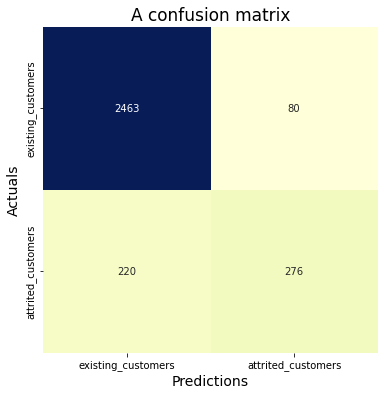

In [10]:
def ConfusionMatrix(y_test, y_pred, label = ["Negative", "Positive"]):
    "A beautiful confusion matrix function to check the model performance"
    cm = confusion_matrix(y_test, y_pred) #get the confusion matrix
    plt.figure(figsize=(6, 6)) 
    sns.heatmap(cm, annot = True, cbar = False, fmt = 'd', cmap = 'YlGnBu')
    plt.xlabel('Predictions', fontsize = 14)
    plt.xticks([0.5, 1.5], label)
    plt.yticks([0.5, 1.5], label)
    plt.ylabel('Actuals', fontsize = 14)
    plt.title('A confusion matrix', fontsize = 17);

#let's find the confusion matrix of the best performing data (label and standard scaling)
ConfusionMatrix(ysl_test, ysl_pred, label= ["existing_customers", "attrited_customers"])

This confusion matrix above shows:

* The logistic regression model correctly classified **2463 customers (True Negatives)** and **276 customers (True Positive)** as exisiting and attrited respectively
* The logistic regression model misjudged **220 customers (False Negatives)** as current customers whereas they are churned, same with **80 customers (False Positives)** that were predicted as attrited customers whereas they are current customers.

# Improving Evaluation Metrics Score

To select which metric (precision or recall) to increase, it is important to ask specific business questions and understand the business case.

*Scenerio 1: if the bank is running at a loss or have a low budget on customer retention, it is best to increase precision score.*

*Scenerio 2: all customers are high value customers and losing them are detrimental to the bank, and the bank will not mind receiving a false churn alarm for existing customer as long as any potential churner doesn't go undetected; it is best to increase recall score.*

When recall is increased, precision reduces and this is known as the **precision/recall tradeoff**.

**Please note:** I will be using the label and standard scaling data to improve the recall and precision score because it is the best performing data in the logistic regression model.

# How to improve Recall/Precision Score

To improve a recall/precision score, you have to do a cut-off optimisation.

There are two way to find the check cut-off:

* Precision recall curve: The curve plots precision scores and recall scores at various probability thresholds
* ROC Curve: The curve plots values of true positive rates (y-axis) against those of false positive rates (x-axis) and these values are plotted at various probability thresholds.

To find the optimal cut-off, I will use:

* Youden's J Statistic: It finds the maximum difference between true positive rate and false positive rate and the probability threshold tied tagged to this largest difference would be the selected one
    
    It is computed as: J = TruePositiveRate + TrueNegativeRate - 1 = TruePositiveRate - FalsePositiveRate

**Precision recall curve**

The purpose of plotting a precision recall curve is to visualize the precision and recall score at any probability threshold.

* It makes it easier to see cut-off that will increase recall or precision
* Cut-off that will have equal recall and precision.

In [11]:
ysl_pred_prob = log_reg.predict_proba(xsl_test) #get the prediction probability
ysl_prob = ysl_pred_prob[:,1] #get class 1 probability

precisions, recalls, thresholds = precision_recall_curve(ysl_test, ysl_prob) #compute the precision score, recall score and cut-off for each instance

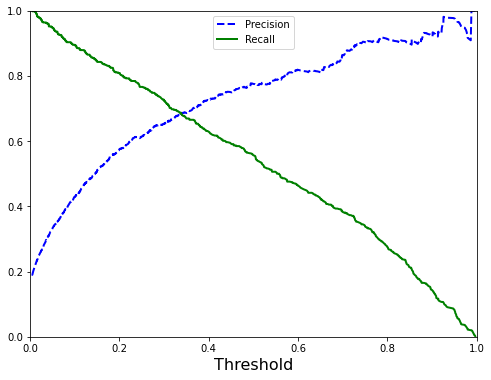

In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)#plot precision score and threshold curve
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)#plot recall score and threshold curve
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper center", fontsize=10)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])
plt.show()

In [13]:
cut_off_df = pd.DataFrame({'cut-off':thresholds, 'recall':recalls[:-1], 'precision':precisions[:-1]}) #show various cut-off, recall score and precision score in a dataframe

**Increase recall score**

* 0.004659 is an extreme cut-off that can increase recall to 99%

In [14]:
pred = (ysl_prob >= 0.004659).astype('int')
print (recall_score(ysl_test, pred))

0.9979838709677419


**Confusion matrix showing new recall score**

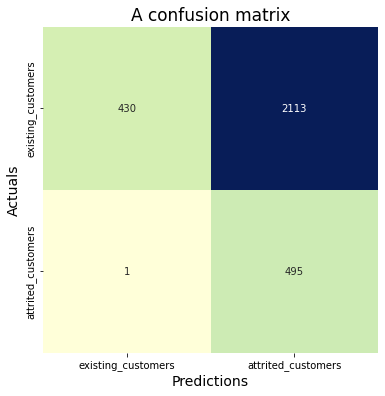

In [15]:
ConfusionMatrix(ysl_test, pred, label= ["existing_customers", "attrited_customers"])

**Increase Precision Score**

* 0.966667 is an extreme cut-off that can increase precision score to 95%

In [16]:
pred = (ysl_prob >= 0.966667).astype('int')
print (precision_score(ysl_test, pred))

0.9473684210526315


**Confusion matrix showing precision score**

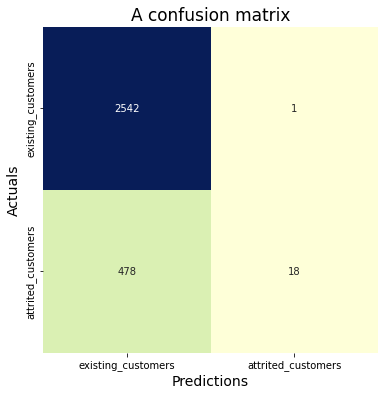

In [17]:
ConfusionMatrix(ysl_test, pred, label= ["existing_customers", "attrited_customers"])

**ROC Curve**

The purpose of plotting a roc curve is to visualize the true positive rate and false positive rate at any probability threshold.

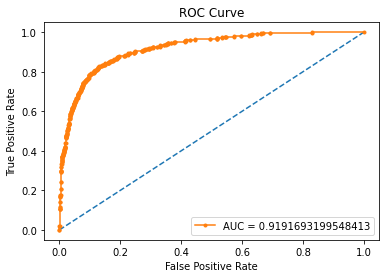

In [18]:
false_pos_rate, true_pos_rate, proba = roc_curve(ysl_test, ysl_pred_prob[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(ysl_test, ysl_pred_prob[:, -1])}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

**Obtain Optimal Probability Cut-off with ROC Curve and Youden's J Statistic**

* Optimal probability cut-off maximizes both recall and precision
* It maximizes true prositives.

In [19]:
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1] #get optimal cut-off
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in ysl_pred_prob[:, -1]]

**Evaluate model with optimal cutoff**

In [20]:
print("Accuracy Score before and after optimal cutoff: {}, {}".format(accuracy_score(ysl_test, ysl_pred), accuracy_score(ysl_test, roc_predictions)))
print("Precision Score before and after optimal cutoff: {}, {}".format(precision_score(ysl_test, ysl_pred), precision_score(ysl_test, roc_predictions)))
print("Recall Score before and after optimal cutoff: {}, {}".format(recall_score(ysl_test, ysl_pred), recall_score(ysl_test, roc_predictions)))
print("F1 Score before and after optimal cutoff: {}, {}".format(f1_score(ysl_test, ysl_pred), f1_score(ysl_test, roc_predictions)))

Accuracy Score before and after optimal cutoff: 0.9012833168805529, 0.8654162553471537
Precision Score before and after optimal cutoff: 0.7752808988764045, 0.5595075239398085
Recall Score before and after optimal cutoff: 0.5564516129032258, 0.8245967741935484
F1 Score before and after optimal cutoff: 0.6478873239436619, 0.6666666666666667


# **Train Random Forest Classifier Model**

In [21]:
#random forest classifier model
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42) #n_estimators is the number of uncorrelated decision trees, max_leaf_nodes is the maximum number of leaf nodes I want each estimator to have.
#random forest classifier model on one-hot encoded data without scaling
rnd_clf.fit(xn_train, yn_train)
rf_yn_pred = rnd_clf.predict(xn_test)

#random forest classifier model on label encoded data without scaling
rnd_clf.fit(xl_train, yl_train)
rf_yl_pred = rnd_clf.predict(xl_test)

#random forest classifier model on one-hot encoded data with robust scaler
rnd_clf.fit(xrn_train, yrn_train)
rf_yrn_pred = rnd_clf.predict(xrn_test)

#random forest classifier model on label encoded data with robust scaler
rnd_clf.fit(xrl_train, yrl_train)
rf_yrl_pred = rnd_clf.predict(xrl_test)

#random forest classifier model on one-hot encoded data with min-max scaler
rnd_clf.fit(xmn_train, ymn_train)
rf_ymn_pred = rnd_clf.predict(xmn_test)

#random forest classifier model on label encoded data with min-max scaler
rnd_clf.fit(xml_train, yml_train)
rf_yml_pred = rnd_clf.predict(xml_test)

#random forest on one-hot encoded data with standard scaler
rnd_clf.fit(xsn_train, ysn_train)
rf_ysn_pred = rnd_clf.predict(xsn_test)

#random forest on label encoded data with standard scaler
rnd_clf.fit(xsl_train, ysl_train)
rf_ysl_pred = rnd_clf.predict(xsl_test)

# Evaluate Random Forest Classifier Model

In [22]:
#let's get the evaluation metrics scores of the random forest classifier model on each 8 different data
rf_eval_metrics = {'data':['one_hot_encoded', 'label_encoded', 'one_hot_enc/robust', 'label_enc/robust', 'one_hot_enc/min_max', 'label_enc/mim_max', 'one_hot_enc/standard', 'label_enc/standard'],
               'Accuracy Score':[accuracy_score(yn_test, rf_yn_pred), accuracy_score(yl_test, rf_yl_pred), accuracy_score(yrn_test, rf_yrn_pred), accuracy_score(yrl_test, rf_yrl_pred), accuracy_score(ymn_test, rf_ymn_pred), accuracy_score(yml_test, rf_yml_pred), accuracy_score(ysn_test, rf_ysn_pred), accuracy_score(ysl_test, rf_ysl_pred)],
               'Precision Score':[precision_score(yn_test, rf_yn_pred), precision_score(yl_test, rf_yl_pred), precision_score(yrn_test, rf_yrn_pred), precision_score(yrl_test, rf_yrl_pred), precision_score(ymn_test, rf_ymn_pred), precision_score(yml_test, rf_yml_pred), precision_score(ysn_test, rf_ysn_pred), precision_score(ysl_test, rf_ysl_pred)],
               'Recall Score':[recall_score(yn_test, rf_yn_pred), recall_score(yl_test, rf_yl_pred), recall_score(yrn_test, rf_yrn_pred), recall_score(yrl_test, rf_yrl_pred), recall_score(ymn_test, rf_ymn_pred), recall_score(yml_test, rf_yml_pred), recall_score(ysn_test, rf_ysn_pred), recall_score(ysl_test, rf_ysl_pred)],
               'F1 Score':[f1_score(yn_test, rf_yn_pred), f1_score(yl_test, rf_yl_pred), f1_score(yrn_test, rf_yrn_pred), f1_score(yrl_test, rf_yrl_pred), f1_score(ymn_test, rf_ymn_pred), f1_score(yml_test, rf_yml_pred), f1_score(ysn_test, rf_ysn_pred), f1_score(ysl_test, rf_ysl_pred)]}

random_forest_perf = pd.DataFrame(rf_eval_metrics) #put the scores in a dataframe
print(tabulate(random_forest_perf, headers = 'keys', tablefmt = 'psql')) #show random_forest-perf dataframe as a table

+----+----------------------+------------------+-------------------+----------------+------------+
|    | data                 |   Accuracy Score |   Precision Score |   Recall Score |   F1 Score |
|----+----------------------+------------------+-------------------+----------------+------------|
|  0 | one_hot_encoded      |         0.906877 |          0.927711 |       0.465726 |   0.620134 |
|  1 | label_encoded        |         0.912471 |          0.916667 |       0.510081 |   0.65544  |
|  2 | one_hot_enc/robust   |         0.906877 |          0.927711 |       0.465726 |   0.620134 |
|  3 | label_enc/robust     |         0.912471 |          0.916667 |       0.510081 |   0.65544  |
|  4 | one_hot_enc/min_max  |         0.906877 |          0.927711 |       0.465726 |   0.620134 |
|  5 | label_enc/mim_max    |         0.912471 |          0.916667 |       0.510081 |   0.65544  |
|  6 | one_hot_enc/standard |         0.906877 |          0.927711 |       0.465726 |   0.620134 |
|  7 | lab

* Random Forest Classifier model is sensitive to the type of categorical encoding but not feature scaling.
    
    Although, there is a difference in label encoded and standard scaled data, this difference is insignificant. 

* The model performed better on label encoded data.

* It has a high accuracy score and precision score of 91%. The recall score is 51%, which is absolutely very low

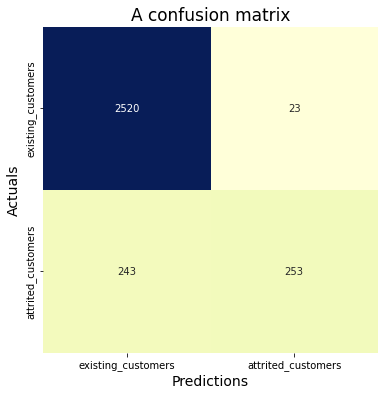

In [23]:
#let's find the confusion matrix of the best performing data (label encoded)
ConfusionMatrix(yl_test, rf_yl_pred, label= ["existing_customers", "attrited_customers"])

# **Train Catboost Classifier Model**

In [24]:
model_cb = CatBoostClassifier(task_type='CPU', iterations=10, random_state=42, eval_metric='F1') #Catboost model
#catboost on one-hot encoded data without scaling
model_cb.fit(xn_train, yn_train)
cb_yn_pred = model_cb.predict(xn_test)

#catboost on label encoded data without scaling
model_cb.fit(xl_train, yl_train)
cb_yl_pred = model_cb.predict(xl_test)

#catboost on one-hot encoded data with robust scaler
model_cb.fit(xrn_train, yrn_train)
cb_yrn_pred = model_cb.predict(xrn_test)

#catboost on label encoded data with robust scaler
model_cb.fit(xrl_train, yrl_train)
cb_yrl_pred = model_cb.predict(xrl_test)

#catboost on one-hot encoded data with min-max scaler
model_cb.fit(xmn_train, ymn_train)
cb_ymn_pred = model_cb.predict(xmn_test)

#catboost on label encoded data with min-max scaler
model_cb.fit(xml_train, yml_train)
cb_yml_pred = model_cb.predict(xml_test)

#catboost on one-hot encoded data with standard scaler
model_cb.fit(xsn_train, ysn_train)
cb_ysn_pred = model_cb.predict(xsn_test)

#catboost on label encoded data with standard scaler
model_cb.fit(xsl_train, ysl_train)
cb_ysl_pred = model_cb.predict(xsl_test)

Learning rate set to 0.5
0:	learn: 0.6105717	total: 63.8ms	remaining: 574ms
1:	learn: 0.7417695	total: 68.9ms	remaining: 276ms
2:	learn: 0.7937468	total: 74ms	remaining: 173ms
3:	learn: 0.8265356	total: 78.7ms	remaining: 118ms
4:	learn: 0.8525214	total: 83.5ms	remaining: 83.5ms
5:	learn: 0.8723303	total: 88.4ms	remaining: 58.9ms
6:	learn: 0.8709981	total: 93.4ms	remaining: 40ms
7:	learn: 0.8809412	total: 98.1ms	remaining: 24.5ms
8:	learn: 0.8877407	total: 103ms	remaining: 11.4ms
9:	learn: 0.8963585	total: 108ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6552646	total: 4.79ms	remaining: 43.1ms
1:	learn: 0.6898701	total: 8.21ms	remaining: 32.9ms
2:	learn: 0.7259640	total: 11.5ms	remaining: 26.9ms
3:	learn: 0.7525151	total: 15.1ms	remaining: 22.6ms
4:	learn: 0.7710233	total: 18.3ms	remaining: 18.3ms
5:	learn: 0.8037943	total: 21.7ms	remaining: 14.4ms
6:	learn: 0.8064032	total: 24.7ms	remaining: 10.6ms
7:	learn: 0.8191227	total: 27.8ms	remaining: 6.95ms
8:	learn: 0.8398438	total: 

In [25]:
#Catboost algorithm recognises categorical columns with text as categories and so can be used directly without converting it to numerical values with any form of encoding
#here's how to do it
x = data.drop(columns='attrition_flag') #make x the feature data
y = data['attrition_flag'] #make y the target data

cat_features = ['gender','education_level','marital_status','income_category','card_category'] #make a list with the names of columns with text categorical data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) #split x and y into training and test set.

model_cb1 = CatBoostClassifier(task_type='CPU', iterations=10, random_state=42, eval_metric='F1') #catboost model

model_cb1.fit(x_train, y_train, cat_features=cat_features, eval_set=(x_test, y_test)) #train the model on the training set and include list of text categorical columns
cb_y_pred = model_cb1.predict(x_test)

Learning rate set to 0.381056
0:	learn: 0.6901339	test: 0.6820276	best: 0.6820276 (0)	total: 15.9ms	remaining: 143ms
1:	learn: 0.7402207	test: 0.7056075	best: 0.7056075 (1)	total: 21.7ms	remaining: 86.8ms
2:	learn: 0.7179487	test: 0.6740741	best: 0.7056075 (1)	total: 27.2ms	remaining: 63.6ms
3:	learn: 0.7595712	test: 0.7047388	best: 0.7056075 (1)	total: 32.4ms	remaining: 48.6ms
4:	learn: 0.7675620	test: 0.7146341	best: 0.7146341 (4)	total: 37.6ms	remaining: 37.6ms
5:	learn: 0.7669405	test: 0.7226277	best: 0.7226277 (5)	total: 42.7ms	remaining: 28.5ms
6:	learn: 0.7899749	test: 0.7579693	best: 0.7579693 (6)	total: 47.7ms	remaining: 20.4ms
7:	learn: 0.8170672	test: 0.7995418	best: 0.7995418 (7)	total: 53.2ms	remaining: 13.3ms
8:	learn: 0.8247926	test: 0.8031674	best: 0.8031674 (8)	total: 59ms	remaining: 6.55ms
9:	learn: 0.8408321	test: 0.8098988	best: 0.8098988 (9)	total: 65ms	remaining: 0us

bestTest = 0.8098987627
bestIteration = 9



# Evaluate Catboost Classifier Model

In [26]:
#make a dictionary that contains the catboost model's accuracy, precision, recall, f1 scores for each 9 different data
cb_eval_metrics = {'data':['one_hot_encoded', 'label_encoded', 'one_hot_enc/robust', 'label_enc/robust', 'one_hot_enc/min_max', 'label_enc/mim_max', 'one_hot_enc/standard',
                           'label_enc/standard', 'non-encoded data'],
                   'Accuracy Score':[accuracy_score(yn_test, cb_yn_pred), accuracy_score(yl_test, cb_yl_pred), accuracy_score(yrn_test, cb_yrn_pred),
                                     accuracy_score(yrl_test, cb_yrl_pred), accuracy_score(ymn_test, cb_ymn_pred),accuracy_score(yml_test, cb_yml_pred),
                                     accuracy_score(ysn_test, cb_ysn_pred), accuracy_score(ysl_test, cb_ysl_pred), accuracy_score(y_test, cb_y_pred)],
                   'Precision Score':[precision_score(yn_test, cb_yn_pred), precision_score(yl_test, cb_yl_pred), precision_score(yrn_test, cb_yrn_pred),
                                      precision_score(yrl_test, cb_yrl_pred), precision_score(ymn_test, cb_ymn_pred), precision_score(yml_test, cb_yml_pred),
                                      precision_score(ysn_test, cb_ysn_pred), precision_score(ysl_test, cb_ysl_pred), precision_score(y_test, cb_y_pred)],
                   'Recall Score':[recall_score(yn_test, cb_yn_pred), recall_score(yl_test, cb_yl_pred), recall_score(yrn_test, cb_yrn_pred),
                                   recall_score(yrl_test, cb_yrl_pred), recall_score(ymn_test, cb_ymn_pred), recall_score(yml_test, cb_yml_pred),
                                   recall_score(ysn_test, cb_ysn_pred), recall_score(ysl_test, cb_ysl_pred), recall_score(y_test, cb_y_pred)],
                   'F1 Score':[f1_score(yn_test, cb_yn_pred), f1_score(yl_test, cb_yl_pred), f1_score(yrn_test, cb_yrn_pred), f1_score(yrl_test, cb_yrl_pred),
                               f1_score(ymn_test, cb_ymn_pred), f1_score(yml_test, cb_yml_pred), f1_score(ysn_test, cb_ysn_pred), f1_score(ysl_test, cb_ysl_pred),
                               f1_score(y_test, cb_y_pred)]}

catboost_perf = pd.DataFrame(cb_eval_metrics) #put the cb_eval_metrics dictionary in a dataframe
print(tabulate(catboost_perf, headers = 'keys', tablefmt = 'psql')) #show dataframe as a table

+----+----------------------+------------------+-------------------+----------------+------------+
|    | data                 |   Accuracy Score |   Precision Score |   Recall Score |   F1 Score |
|----+----------------------+------------------+-------------------+----------------+------------|
|  0 | one_hot_encoded      |         0.957223 |          0.917808 |       0.810484 |   0.860814 |
|  1 | label_encoded        |         0.946364 |          0.925831 |       0.729839 |   0.816234 |
|  2 | one_hot_enc/robust   |         0.957223 |          0.917808 |       0.810484 |   0.860814 |
|  3 | label_enc/robust     |         0.946364 |          0.925831 |       0.729839 |   0.816234 |
|  4 | one_hot_enc/min_max  |         0.957223 |          0.917808 |       0.810484 |   0.860814 |
|  5 | label_enc/mim_max    |         0.946364 |          0.925831 |       0.729839 |   0.816234 |
|  6 | one_hot_enc/standard |         0.957223 |          0.917808 |       0.810484 |   0.860814 |
|  7 | lab

* Catboost is also not sensitive to feature scaling, performs best on one-hot encoding data.

    Catboost can work directly with text, categorical and numerical data.

* It has a good accuracy and precision score of 94% and 91.6% respectively. The recall score is 72.5%, which can be increased depending on bank approach to retain customers.

# **Train XGBOOST Classifier Model**

In [27]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=1, objective='binary:logistic') #XGBoost classifier model
#xgboost classifier on one-hot encoded data without scaling
xgb_clf.fit(xn_train, yn_train)
xgb_yn_pred = xgb_clf.predict(xn_test)

#xgboost classifier on label encoded data without scaling
xgb_clf.fit(xl_train, yl_train)
xgb_yl_pred = xgb_clf.predict(xl_test)

#xgboost classifier on one-hot encoded data with robust scaler
xgb_clf.fit(xrn_train, yrn_train)
xgb_yrn_pred = xgb_clf.predict(xrn_test)

#xgboost classifier on label encoded data with robust scaler
xgb_clf.fit(xrl_train, yrl_train)
xgb_yrl_pred = xgb_clf.predict(xrl_test)

#xgboost classifier on one-hot encoded data with min-max scaler
xgb_clf.fit(xmn_train, ymn_train)
xgb_ymn_pred = xgb_clf.predict(xmn_test)

#xgboost classifier on label encoded data with min-max scaler
xgb_clf.fit(xml_train, yml_train)
xgb_yml_pred = xgb_clf.predict(xml_test)

#xgboost classifier on one-hot encoded data with standard scaler
xgb_clf.fit(xsn_train, ysn_train)
xgb_ysn_pred = xgb_clf.predict(xsn_test)

#xgboost classifier on label encoded data with standard scaler
xgb_clf.fit(xsl_train, ysl_train)
xgb_ysl_pred = xgb_clf.predict(xsl_test)

# Evaluate Xgboost Classifier Model

In [28]:
#make a dictionary that contains the xgboost classifier model's accuracy, precision, recall, f1 scores for each 8 different data
xgb_eval_metrics = {'data':['one_hot_encoded', 'label_encoded', 'one_hot_enc/robust', 'label_enc/robust', 'one_hot_enc/min_max', 'label_enc/mim_max', 'one_hot_enc/standard',
                           'label_enc/standard'],
                   'Accuracy Score':[accuracy_score(yn_test, xgb_yn_pred), accuracy_score(yl_test, xgb_yl_pred), accuracy_score(yrn_test, xgb_yrn_pred),
                                     accuracy_score(yrl_test, xgb_yrl_pred), accuracy_score(ymn_test, xgb_ymn_pred),accuracy_score(yml_test, xgb_yml_pred),
                                     accuracy_score(ysn_test, xgb_ysn_pred), accuracy_score(ysl_test, xgb_ysl_pred)],
                   'Precision Score':[precision_score(yn_test, xgb_yn_pred), precision_score(yl_test, xgb_yl_pred), precision_score(yrn_test, xgb_yrn_pred),
                                      precision_score(yrl_test, xgb_yrl_pred), precision_score(ymn_test, xgb_ymn_pred), precision_score(yml_test, xgb_yml_pred),
                                      precision_score(ysn_test, xgb_ysn_pred), precision_score(ysl_test, xgb_ysl_pred)],
                   'Recall Score':[recall_score(yn_test, xgb_yn_pred), recall_score(yl_test, xgb_yl_pred), recall_score(yrn_test, xgb_yrn_pred),
                                   recall_score(yrl_test, xgb_yrl_pred), recall_score(ymn_test, xgb_ymn_pred), recall_score(yml_test, xgb_yml_pred),
                                   recall_score(ysn_test, xgb_ysn_pred), recall_score(ysl_test, xgb_ysl_pred)],
                   'F1 Score':[f1_score(yn_test, xgb_yn_pred), f1_score(yl_test, xgb_yl_pred), f1_score(yrn_test, xgb_yrn_pred), f1_score(yrl_test, xgb_yrl_pred),
                               f1_score(ymn_test, xgb_ymn_pred), f1_score(yml_test, xgb_yml_pred), f1_score(ysn_test, xgb_ysn_pred), f1_score(ysl_test, xgb_ysl_pred)]}

xgboost_perf = pd.DataFrame(xgb_eval_metrics) #put the xgb_eval_metrics dictionary in a dataframe
print(tabulate(xgboost_perf, headers = 'keys', tablefmt = 'psql')) #visualise each evaluation metric using a table

+----+----------------------+------------------+-------------------+----------------+------------+
|    | data                 |   Accuracy Score |   Precision Score |   Recall Score |   F1 Score |
|----+----------------------+------------------+-------------------+----------------+------------|
|  0 | one_hot_encoded      |         0.959855 |          0.887967 |       0.862903 |   0.875256 |
|  1 | label_encoded        |         0.963804 |          0.897119 |       0.879032 |   0.887984 |
|  2 | one_hot_enc/robust   |         0.959855 |          0.887967 |       0.862903 |   0.875256 |
|  3 | label_enc/robust     |         0.963804 |          0.897119 |       0.879032 |   0.887984 |
|  4 | one_hot_enc/min_max  |         0.959855 |          0.887967 |       0.862903 |   0.875256 |
|  5 | label_enc/mim_max    |         0.963804 |          0.897119 |       0.879032 |   0.887984 |
|  6 | one_hot_enc/standard |         0.959855 |          0.887967 |       0.862903 |   0.875256 |
|  7 | lab

* XGBoost is affected by encoding but not affected by feature scaling. It performed best on the label encoded data.

* This model has a fairly good overall performance. Accuracy score - 96.3%, Precision score - approximately 90%, Recall score - approximately 88%.**

# **Train LightGBM**

In [29]:
lgb_clf = LGBMClassifier() #lightGBM Classifier model

#lightgbm on one-hot encoded data without scaling
lgb_clf.fit(xn_train, yn_train)
lgb_yn_pred = lgb_clf.predict(xn_test)

#lightgbm on label encoded data without scaling
lgb_clf.fit(xl_train, yl_train)
lgb_yl_pred = lgb_clf.predict(xl_test)

#lightgbm on one-hot encoded data with robust scaler
lgb_clf.fit(xrn_train, yrn_train)
lgb_yrn_pred = lgb_clf.predict(xrn_test)

#lightgbm on label encoded data with robust scaler
lgb_clf.fit(xrl_train, yrl_train)
lgb_yrl_pred = lgb_clf.predict(xrl_test)

#lightgbm on one-hot encoded data with min-max scaler
lgb_clf.fit(xmn_train, ymn_train)
lgb_ymn_pred = lgb_clf.predict(xmn_test)

#lightgbm on label encoded data with min-max scaler
lgb_clf.fit(xml_train, yml_train)
lgb_yml_pred = lgb_clf.predict(xml_test)

#lightgbm on one-hot encoded data with standard scaler
lgb_clf.fit(xsn_train, ysn_train)
lgb_ysn_pred = lgb_clf.predict(xsn_test)

#lightgbm on label encoded data with standard scaler
lgb_clf.fit(xsl_train, ysl_train)
lgb_ysl_pred = lgb_clf.predict(xsl_test)

# Evaluate LightGBM Model

In [30]:
#make a dictionary that contains the lightGBM classifier model's accuracy, precision, recall, f1 scores for each 8 different data
lgb_eval_metrics = {'data':['one_hot_encoded', 'label_encoded', 'one_hot_enc/robust', 'label_enc/robust', 'one_hot_enc/min_max', 'label_enc/mim_max', 'one_hot_enc/standard',
                           'label_enc/standard'],
                   'Accuracy Score':[accuracy_score(yn_test, lgb_yn_pred), accuracy_score(yl_test, lgb_yl_pred), accuracy_score(yrn_test, lgb_yrn_pred),
                                     accuracy_score(yrl_test, lgb_yrl_pred), accuracy_score(ymn_test, lgb_ymn_pred),accuracy_score(yml_test, lgb_yml_pred),
                                     accuracy_score(ysn_test, lgb_ysn_pred), accuracy_score(ysl_test, lgb_ysl_pred)],
                   'Precision Score':[precision_score(yn_test, lgb_yn_pred), precision_score(yl_test, lgb_yl_pred), precision_score(yrn_test, lgb_yrn_pred),
                                      precision_score(yrl_test, lgb_yrl_pred), precision_score(ymn_test, lgb_ymn_pred), precision_score(yml_test, lgb_yml_pred),
                                      precision_score(ysn_test, lgb_ysn_pred), precision_score(ysl_test, lgb_ysl_pred)],
                   'Recall Score':[recall_score(yn_test, lgb_yn_pred), recall_score(yl_test, lgb_yl_pred), recall_score(yrn_test, lgb_yrn_pred),
                                   recall_score(yrl_test, lgb_yrl_pred), recall_score(ymn_test, lgb_ymn_pred), recall_score(yml_test, lgb_yml_pred),
                                   recall_score(ysn_test, lgb_ysn_pred), recall_score(ysl_test, lgb_ysl_pred)],
                   'F1 Score':[f1_score(yn_test, lgb_yn_pred), f1_score(yl_test, lgb_yl_pred), f1_score(yrn_test, lgb_yrn_pred), f1_score(yrl_test, lgb_yrl_pred),
                               f1_score(ymn_test, lgb_ymn_pred), f1_score(yml_test, lgb_yml_pred), f1_score(ysn_test, lgb_ysn_pred), f1_score(ysl_test, lgb_ysl_pred)]}

lightgbm_perf = pd.DataFrame(lgb_eval_metrics) #create a dataframe from the dictionary - lgb_eval_metrics
print(tabulate(lightgbm_perf, headers = 'keys', tablefmt = 'psql')) #show in tabular form

+----+----------------------+------------------+-------------------+----------------+------------+
|    | data                 |   Accuracy Score |   Precision Score |   Recall Score |   F1 Score |
|----+----------------------+------------------+-------------------+----------------+------------|
|  0 | one_hot_encoded      |         0.965449 |          0.903093 |       0.883065 |   0.892966 |
|  1 | label_encoded        |         0.968082 |          0.914761 |       0.887097 |   0.900716 |
|  2 | one_hot_enc/robust   |         0.966436 |          0.897177 |       0.897177 |   0.897177 |
|  3 | label_enc/robust     |         0.966436 |          0.90535  |       0.887097 |   0.89613  |
|  4 | one_hot_enc/min_max  |         0.965778 |          0.904959 |       0.883065 |   0.893878 |
|  5 | label_enc/mim_max    |         0.965778 |          0.901639 |       0.887097 |   0.894309 |
|  6 | one_hot_enc/standard |         0.966765 |          0.907216 |       0.887097 |   0.897044 |
|  7 | lab

* LightGBM is sensitive to the type of categorical encoding done and data normalization

* The model performed best on label encoded data with standard scaling

* This is an impressive model. It has a 96.8% accuracy score, 91.1% precision score, 89.3% recall score.

* Overall, lightgbm classifier performed better than XGBoost, CatBoost, Random Forest and Logistic Regression.

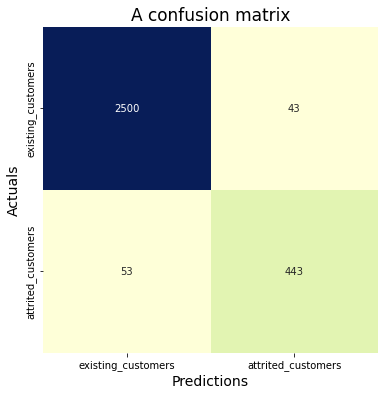

In [31]:
#let's find the confusion matrix of the best performing data (label encoded/standard scaling)
ConfusionMatrix(ysl_test, lgb_ysl_pred, label= ["existing_customers", "attrited_customers"])

**This is the best so far!**

# **Is the Models overfitting/underfitting?**

In Machine Learning, overfitting and underfitting is major concept to check if model is performing well because it has memorized the training data or if it will retain its excellent performance in a new input data. Let's check all the models.

In [32]:
#To check if Logistic Regression is overfitting for its best performance data (label_encoded-standard scaling)
ysl_train_pred = log_reg.predict(xsl_train) #make prediction on training set
#print('The accuracy score of log reg on the training set: ',accuracy_score(ysl_train, ysl_train_pred)) #check accuracy score on training set
#print('The accuracy score of log reg on the test set: ',accuracy_score(ysl_test, ysl_pred)) #check accuracy score on test set

In [33]:
#To check if Random Forest Classifier is overfitting for its best performance data (label_encoded)
rf_ytrain_pred = rnd_clf.predict(xl_train)#make prediction on training set
#print('The accuracy score of rnd_clf on the training set: ',accuracy_score(yl_train, rf_ytrain_pred)) #check accuracy on training set
#print('The accuracy score of rnd_clf on the test set: ',accuracy_score(yl_test, rf_yl_pred)) #check accuracy on test set

In [34]:
#To check if CatBoost is overfitting for its best performance data (label_encoded)
cb_train_pred = model_cb.predict(xn_train) #make prediction on training set
#print('The accuracy score of catboost model on the training set: ',accuracy_score(yn_train, cb_train_pred)) #check accuracy on training set
#print('The accuracy score of catboost model on the test set: ',accuracy_score(yn_test, cb_yn_pred)) #check accuracy on test set

In [35]:
#To check if XGBoost is overfitting for its best performance data (label_encoded)
xgb_ytrain_pred = xgb_clf.predict(xl_train)#prediction of train set
#print('The accuracy score of Xgboost model on the training set: ',accuracy_score(yl_train, xgb_ytrain_pred)) #check accuracy on train set
#print('The accuracy score of Xgbboost model on the test set: ',accuracy_score(yl_test, xgb_yl_pred)) #check accuracy on test set

In [36]:
#To check if LightGBM is overfitting for its best performance data (label_encoded-standard scaling)
lgb_ytrain_pred = lgb_clf.predict(xsl_train)#prediction of train set
#print('The accuracy score of Lightgbm model on the train set: ', accuracy_score(ysl_train, lgb_ytrain_pred))#check accuracy on train set
#print('The accuracy score of Lightgbm model on the test set: ',accuracy_score(ysl_test, lgb_ysl_pred))#check accuracy on test set

* The accuracy scores of the logistic regression model shows that the model is neither underfitting nor overfitting.
* There is a disparity between the random forest classifier model's accuracy scores on training and test set. The accuracy score on the train set is 84% while that of test set is 91%. The lower score on the train set is because random forest classifier is a tree-based algorithm, it makes its decision through voting and this tends to reduce accuracy score on train set. That being said, the model is also not overfitting/underfitting because it has a pretty good score. 
* CatBoost Model is not overfitting because its accuracy score on test set is higher than the accuracy score on train set. I also wouldn't say that it is underfitting because a model that is underfitting gives a general low performance score on both train and test set. The reason for the 54.8% accuracy score is because the CatBoost model is tree-based.
* XGBoost Model is not overfitting or underfitting. It is also a tree-based algorithm, hence the lower accuracy score of 53% on the training set.
* The lightgbm model gives a 100% accuracy score on the training set and a lower performance of 96.8% on the test set. The difference between the train set and test set accuracy scores is 3.2%. This is the only model that has a higher accuracy score on training set and lower accuracy score on test set. The reason is that Light GBM split the tree leaf-wise which can lead to overfitting as it produces much complex trees. Light GBM is sensitive to overfitting and thus can easily overfit small data. To confirm if this applies to the model, let's evaluate the model's accuracy score using cross-validation.


# **LightGBM Model Evaluation using Cross-Validation**

Cross-validation is an important concept in machine learning. It is a technique used to evaluate ML models by training an ML model on subsets of the available input data and evaluating them on the complementary subset of the data. It can detect if our data is overfitting, that is, failing to generalize a pattern.

Let’s use the cross_val_score() function to evaluate the LGBMClassifier models that is already showing signs of overfitting, using K-fold cross-validation with ten folds.

In [37]:
#cross validation on lightgbm model
lgb_scores = cross_val_score(lgb_clf, xsl_train, ysl_train, scoring="accuracy", cv=10, n_jobs=-1)

#print("Accuracy scores: ", np.round(lgb_scores, 2)) #to get accuracy score of each folds
#print("Average accuracy: ", np.round(np.mean(lgb_scores), 2)) #to get average accuracy

* The model performed considerably well in similar range across the 10 different subset.

* lightgbm model attained an average of 97% accuracy score of 10 folds, which has only a difference of 0.2% (highly insignificant) when compared to the accuracy score of 96.8%.

* **This confirms that the lightgbm model is not overfitting.**

# **Lift Curve and Gain**

Lift and gain curve/charts are used to evaluate performance of classification model. It is not enough to rely on the technical metrics but on how our model impacts the business. They measure the usefulness of a predictive model by comparing to a no model situation.It is very popular in customer related analysis such as churn prediction, marketing prediction, etc. Generally it evaluates the model prediction and the benefit to the business.

**Gain:** Gain at a given decile level is the ratio of cumulative number of targets (events) up to that decile to the total number of targets (events) in the entire data set

**Lift:** It measures how much better one can expect to do with the predictive model comparing without a model. It is the ratio of gain % to the random expectation % at a given decile level. The random expectation at the xth decile is x%.

# How to perform Lift and Gain Manually?

To build the lift and gain from scratch, use a label encoded data that do not have any feature scaling - in this case, xl_test

In [38]:
xl_test1=xl_test.copy() #make a copy of xl_test

In [39]:
#Getting the prediction probability of class 1 and order it by descending order
xl_test1['prob']  = lgb_clf.predict_proba(xl_test1)[:,1]
xl_test1 = xl_test1.sort_values(by = 'prob', ascending = False)
xl_test1['churn'] = yl_test

#Get the last two columns recently added
new_df = xl_test1.iloc[:,-2:]

#Divide the data into decile
new_df['Decile'] = pd.qcut(new_df['prob'], 10, labels=[i for i in range (10, 0, -1)])

#Calculate the actual churn in each decile
res = pd.crosstab(new_df['Decile'], new_df['churn'])[1].reset_index().rename(columns = {1: 'Number of Responses'})
lg = new_df['Decile'].value_counts(sort = False).reset_index().rename(columns = {'Decile': 'Number of Cases', 'index': 'Decile'})
lg = pd.merge(lg, res, on = 'Decile').sort_values(by = 'Decile', ascending = False).reset_index(drop = True)

#Calculate the cumulative
lg['Cumulative Responses'] = lg['Number of Responses'].cumsum()
#Calculate the percentage of positive in each decile compared to the total nu
lg['% of Events'] = np.round(((lg['Number of Responses']/lg['Number of Responses'].sum())*100),2)
#Calculate the Gain in each decile
lg['Gain'] = lg['% of Events'].cumsum()

#Calculate the lift in each decile
lg['Decile'] = lg['Decile'].astype('int')
lg['lift'] = np.round((lg['Gain']/(lg['Decile']*10)),2)

* **In this lightgbm churn model, we can target 65.7% churners by reaching out to 50% of our customers.**
* **The lift is 1.31. This means the churn target could be found 1.31 times more than in a random selection of 50% of the population.**

# **Visualisation of Gain for the five models**

Kds is a library supported by Python. I will use kds to plot a gain chart, this is a simpler way to get the gain rather than the manual method done above. Also, this method can handle data with or without feature scaling.

I will plot a gain chart for the lightgbm, xgboost, catboost, random forest and logistic regression models with each of their best performing data.

In [40]:
pip install kds

Note: you may need to restart the kernel to use updated packages.


LightGBM Model used for the manual method


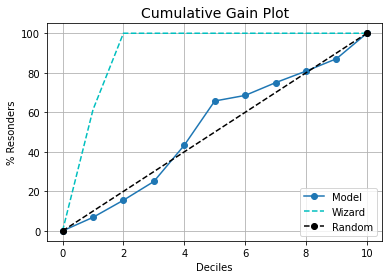

In [41]:
import kds #import kds library
#Gain of lightGBM on label encoded data used in lg
lgb_p  = lgb_clf.predict_proba(xl_test) #get the prediction probability of the test set
print('LightGBM Model used for the manual method')
kds.metrics.plot_cumulative_gain(yl_test, lgb_p[:,1]) #plot the gain chart

In terms of gain, this model is almost similar to a random (without model). 50% customer has to be reached to target only 64% of churners.

LightGBM Model


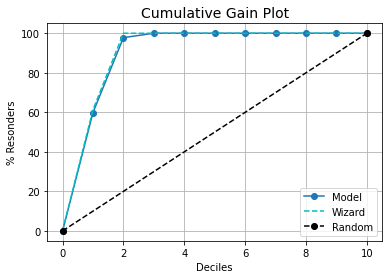

In [42]:
#Gain of lightgbm on standard scaler and label encoded data
lgb_ysl_p = lgb_clf.predict_proba(xsl_test)
print('LightGBM Model')
kds.metrics.plot_cumulative_gain(ysl_test, lgb_ysl_p[:,1])

**Remember that this the best performing model. With this model, 98% of churners will be reached through any customer retention plan on 20% of the entire customer.**

Xgboost Model


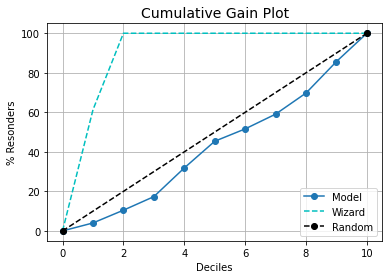

In [43]:
#Gain of Xgboost on label encoded data without feature scaling
xgb_p = xgb_clf.predict_proba(xl_test)
print('Xgboost Model')
kds.metrics.plot_cumulative_gain(yl_test, xgb_p[:,1])

The Xgboost model has a very poor gain.

Catboost Model


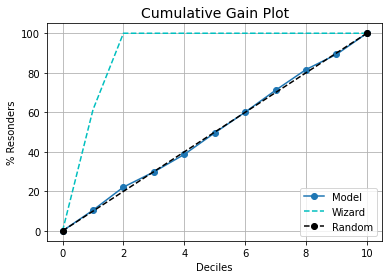

In [44]:
#Gain of Catboost on one hot encoded data without feature scaling
cb_p = model_cb.predict_proba(xn_test)
print('Catboost Model')
kds.metrics.plot_cumulative_gain(yn_test, cb_p[:,1])

Business-wise, implementing the catboost model would be expensive. The chart shows that there is no significant difference between the model and without the model.

Random Forest Model


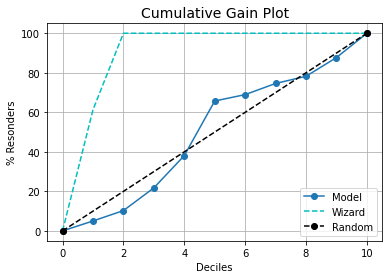

In [45]:
#Gain of Xgboost on label encoded data without feature scaling 
rf_p = rnd_clf.predict_proba(xl_test)
print('Random Forest Model')
kds.metrics.plot_cumulative_gain(yl_test, rf_p[:,1])

This random forest model will also be expensive to implement.

Logistic Regression Model


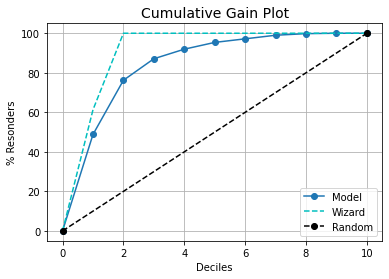

In [46]:
#Gain of Logistic Regression on standard scaler and label encoded data
ysl_p = log_reg.predict_proba(xsl_test)
print('Logistic Regression Model')
kds.metrics.plot_cumulative_gain(ysl_test, ysl_p[:,1])

**Despite being the least performing model, logistic regression model will be a good model choice. With it the bank can cover 72% of churners through 20% of customers.**

# **Visualize lift plot for the two models with good gain**

The two models are LightGBM and Logistic regression

LightGBM Model


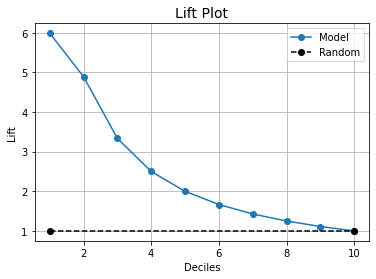

In [47]:
#Lift of LightGBM on standard scaler and label encoded data
lgb_p #the prediction probability of xsl_test using the lightGBM model
print('LightGBM Model')
kds.metrics.plot_lift(ysl_test, lgb_ysl_p[:,1]) #plot lift curve

In decile 2, we have 4.9 which means that when selecting 20% of the data based on the lightgbm model, we could find the target (actual positive) 4.9 times more than the randomly selected 20% of the data without a model.

Logistic Regression Model


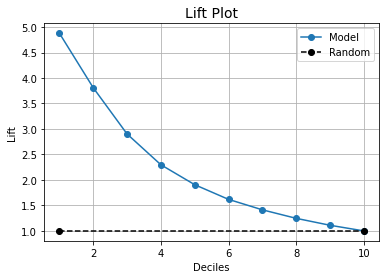

In [48]:
#Lift of Logistic Regression on standard scaler and label encoded data
ysl_p #the prediction probability of xsl_test using the Logistic Regression model
print('Logistic Regression Model')
kds.metrics.plot_lift(ysl_test, ysl_p[:,1])

In decile 2, we have 3.8 which means that when selecting 20% of the data based on the xgboost model, we could find the target (actual positive) 4.8 times more than the randomly selected 20% of the data without a model.

# **Conclusion**

Based on the five models and data preprocessing techniques I applied, this is a summary of what I have learnt:

1. Most Tree-based models such as random forest, catboost, xgboost do not require feature scaling. However, random forest and xgboost perform better with label encoding while catboost performs well with one-hot encoding.

2. The tree-based models listed above had a low accuracy score on training set but good score on test set. This is because tree-based model uses voting techniques to select the best model, this makes it hard for the model to overfit.

3. LightGBM in contrast to all the other tree-based model requires feature scaling (for this datset, standard scaling was appropriate) and performs better on label encoded data.

4. Logistic regression requires feature scaling as well. Similar to the lightGBM model, it perfoms better on label encoded data.

5. The best technique for pre-processing the data is standard scaling. Unlike the initial concept that robust scaling is good for outliers and non-uniform distributed data, it is good to know to what extent. How big is the outliers? the number of columns exhibiting a non-uniform distribution?

6. The fact that a model performs better in terms of accuracy, precision and recall score doesn't mean that it will have a good gain analysis. Not all high performing models will be good to implement in terms of business.

7. The type of feature scaling done on data affects gain of a model. 

8. In addition, to increase precision score - raise the classification threshold; to increase recall score - reduce the classification threshold.

9. It is important to consider your business model when selecting a model and metrics to evaluate the model performance. If the business model of the bank is not customer-centric and very low budget are assigned to customer retention plan, customer churn prediction model should be evaluated using precision score, gain and lift. A high precision score implies that all customers predicted by the model to churn are actual churners. A good gain curve that is equal or higher than the pareto principle of 20-80 would suggest that 80% or more percentage of churners would be targeted by applying the bank's customer retention plan on 20% of customers. A good lift curve would suggest how faster the bank would reach churners with the model rather than without it.

10. Generally, LightGBM is the best performing model!

# **References**

Below is a list of resources I used:

* Feature Scaling Technique - https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/
* One hot encoding - https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769
* Overfitting - https://www.v7labs.com/blog/overfitting
* Pareto Principle - https://en.wikipedia.org/wiki/Pareto_principle
* Lift of Churn Model - https://businessforecastblog.com/whats-the-lift-of-your-churn-model-predictive-analytics-and-big-data/
* Lift and Gain Analysis - https://towardsdatascience.com/model-benefit-evaluation-with-lift-and-gain-analysis-4b69f9288ab3

Books:

* Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron
* Feature Engineering for Machine Learning by Alice Zheng & Amanda Casari